##### Copyright 2020 The Cirq Developers

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum circuits on Pasqal devices

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/hardware/pasqal/getting_started"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/main/docs/hardware/pasqal/getting_started.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/main/docs/hardware/pasqal/getting_started.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/hardware/pasqal/getting_started.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

In [2]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")
    import cirq
import cirq_pasqal
from cirq_pasqal import ThreeDQubit, TwoDQubit, PasqalVirtualDevice, PasqalNoiseModel

<img src="../../images/pasqal/Cirq_pasqal.png" width="700"/>

In this notebook, we show how to program a quantum circuit for Pasqal using cirq. The first step is to import cirq, and Pasqal custom classes. We use ``PasqalVirtualDevice`` to showcase how Cirq enforces Pasqal's devices' restrictions throughout the process.

## Create an array of qubits on a lattice

The QPU of Pasqal is made of neutral atoms controlled by lasers. Individual atoms are trapped at well-defined positions in 1, 2 or even 3D, as shown on the following plot ( [Nature 561, 79 (2018)](https://www.nature.com/articles/s41586-018-0450-2)).

<img src="../../images/pasqal/eiffel_tower.png" width="500"/>

We created a custom class in Cirq, ThreeDQubit, that corresponds to a qubit placed in 3D space. Let us start by creating a register comprising $36=6\times6$ qubits in 2D, regularly arranged on a square lattice. It corresponds to the following configuration (image taken from [Nature 561, 79 (2018)](https://www.nature.com/articles/s41586-018-0450-2))

<img src="../../images/pasqal/grid_atoms.png" width="300"/>

In [3]:
width = 6
height = 6
depth = 1
# Creating p_qubits, a list of ThreeDQubits.
p_qubits = [
    ThreeDQubit(row, col, layer)
    for row in range(width)
    for col in range(height)
    for layer in range(depth)
]

Notice how we are fixing `depth=1` to keep all qubits in the $z=0$ plane. The same can also be achieved by using the `TwoDQubit` class, which is nothing more than a `ThreeDQubit` confined to the `z=0` plane. We can create the same $6 x 6$ square array, this time using one of the built-in methods:

In [4]:
p_qubits = TwoDQubit.square(6)  # 6x6 square array of TwoDQubits

## Create a PasqalDevice

Multi-qubit gates can be applied between qubits in the device, provided that the distance between them is smaller than the so-called Rydberg blocade radius (or control radius), that can be passed as a parameter of the device (in units of the lattice size). Here, we instantiate a `PasqalVirtualDevice` with 36 qubits and a control radius of $2.1$. 

This `PasqalVirtualDevice` can be used to validate the operations within a `Circuit`.

In [5]:
# Initialize and create a circuit
initial_circuit = cirq.Circuit()
initial_circuit.append(cirq.CZ(p_qubits[0], p_qubits[1]))
initial_circuit.append(cirq.Z(p_qubits[0]))
initial_circuit.append(cirq.CX(p_qubits[0], p_qubits[2]))

# Create a Pasqal device with a control radius of 2.1 (in units of the lattice spacing)
p_device = PasqalVirtualDevice(control_radius=2.1, qubits=p_qubits)

# Validate the circuit using the device
try:
    p_device.validate_circuit(initial_circuit)
except ValueError as e:
    # Uh oh!  This circuit does not pass validation.
    print(e)

cirq.CNOT is not a supported gate


Notice that the `CX` gate, also called a `CNOT` gate is not valid on this device.  We can use a `PasqalGateset` object with the built-in cirq method `cirq.optimize_for_target_gateset` to convert it.  This will convert the logical gates into native hardware gates.  

In [6]:
pasqal_gateset = cirq_pasqal.PasqalGateset(include_additional_controlled_ops=False)
pasqal_circuit = cirq.optimize_for_target_gateset(initial_circuit, gateset=pasqal_gateset)

# TODO(https://github.com/quantumlib/Cirq/issues/6655) - remove after fixup
pasqal_circuit = cirq.Circuit(pasqal_circuit.all_operations(), strategy=cirq.InsertStrategy.NEW)

print(pasqal_circuit)

# Now the circuit validates correctly!
p_device.validate_circuit(pasqal_circuit)

(0, 0): ───@───Z───────────────────@──────────────────
           │                       │
(1, 0): ───@───────────────────────┼──────────────────
                                   │
(2, 0): ───────────PhX(-0.5)^0.5───@───PhX(0.5)^0.5───


When inserting into circuits designed for Pasqal devices, be sure to insert each operation into its own `Moment` (for example, using `cirq.InsertStrategy.NEW`).  You may need to do this in a separate step, as in the below example that converts two simultaneous Hadamard gates.

In [7]:
initial_circuit = cirq.Circuit()
initial_circuit.append(cirq.H(p_qubits[0]))
initial_circuit.append(cirq.H(p_qubits[1]))
print('Initial Circuit, does not pass validation:')
print(initial_circuit)
try:
    p_device.validate_circuit(initial_circuit)
except ValueError as e:
    # Uh oh!  This circuit does not pass validation.
    print(e)

pasqal_circuit = cirq.Circuit(initial_circuit.all_operations(), strategy=cirq.InsertStrategy.NEW)
print('')
print('Converted Circuit, passes validation:')
print(pasqal_circuit)

# Now the circuit validates correctly!
p_device.validate_circuit(pasqal_circuit)

Initial Circuit, does not pass validation:
(0, 0): ───H───

(1, 0): ───H───
Cannot do simultaneous gates. Use cirq.InsertStrategy.NEW.

Converted Circuit, passes validation:
(0, 0): ───H───────

(1, 0): ───────H───


When the distance between the two qubits involved in the gate is greater than the control radius, as shown for example in the following plot, Cirq will raise an error.

<img src="../../images/pasqal/r_radius.001.png" width="300"/><br>

In [8]:
# It is impossible to add a multi-qubit gate if the qubits involved are too far away
try:
    p_device.validate_operation(cirq.CZ(p_qubits[0], p_qubits[-1]))
except ValueError as msg:
    print("ERROR:", msg)
else:
    print("Failed to raise the expected ValueError.")

ERROR: Qubits pasqal.TwoDQubit(0, 0), pasqal.TwoDQubit(5, 5) are too far away


## Send a circuit to a remote Pasqal machine

Using the Circuit class of Cirq, one can then build a circuit that will be implemented with one of Pasqal's devices as a backend.

The real QPU is not plugged in yet as a backend. If you send us your circuit, we currently use a classical emulator as a backend to determine the result of your simulation. As emulating a quantum circuit with a large number of qubits is computationnaly intensive, here we choose to realize a circuit on a smaller register.

More precisely, we will implement Grover's algorithm to search for the state $|10\rangle$, which corresponds to the circuit:

<img src="../../images/pasqal/Grover_circuit.png" width="750"/><br>

Bear in mind that this is a naïve implementation that can be substantially optimized, particularly in the oracle and the usage of an ancilla, but that is beyond the scope of this tutorial.

Here is the Cirq implementation of the circuit using generators:

In [9]:
import numpy as np

# Place qubits at vertices of an equilateral triangle
qs = [TwoDQubit(0, 0), TwoDQubit(1, 0), TwoDQubit(0.5, np.sqrt(3) / 2)]
q_meas = [TwoDQubit(1, 0), TwoDQubit(0, 0)]


def state_preparation():
    for q in qs[:-1]:
        yield cirq.H(q)
    yield cirq.X(qs[-1])
    yield cirq.H(qs[-1])


def oracle():
    # Signals the state 10
    yield cirq.X(qs[0])
    yield cirq.CCX(*qs)
    yield cirq.X(qs[0])


def grover_operator():
    for q in qs[:-1]:
        yield cirq.H(q)
        yield cirq.X(q)

    yield cirq.CZ(*qs[:-1])

    for q in qs[:-1]:
        yield cirq.X(q)
        yield cirq.H(q)


def generate_grover():
    yield state_preparation()
    yield oracle()
    yield grover_operator()


def generate_pasqal_grover():
    pasqal_gateset = cirq_pasqal.PasqalGateset(include_additional_controlled_ops=False)
    grover_cicruit = cirq.optimize_for_target_gateset(
        cirq.Circuit(generate_grover()), gateset=pasqal_gateset
    )
    return cirq.Circuit(grover_cicruit.all_operations(), strategy=cirq.InsertStrategy.NEW)


device = PasqalVirtualDevice(control_radius=1.1, qubits=qs)
grover_circuit = generate_pasqal_grover()
device.validate_circuit(grover_circuit)
grover_circuit.append(cirq.measure(*q_meas, key='x'))

Now, to execute the circuit on one of our servers, one has to create a sampler that will send the circuit to the remote host address. One currently needs a token to do this. Please contact us to get one !

In [10]:
# To execute on one of Pasqal's servers, get an access token and uncomment these lines
# sampler = cirq_pasqal.PasqalSampler(remote_host='http://34.98.71.118/v0/pasqal',
#                                     access_token='')

Alternatively, small circuits can also be simulated locally using Cirq's `Simulator`, which we will do here. 

In [11]:
sampler = cirq.Simulator()
data_raw = sampler.run(grover_circuit, repetitions=200)

Next, we can plot the results obtained.

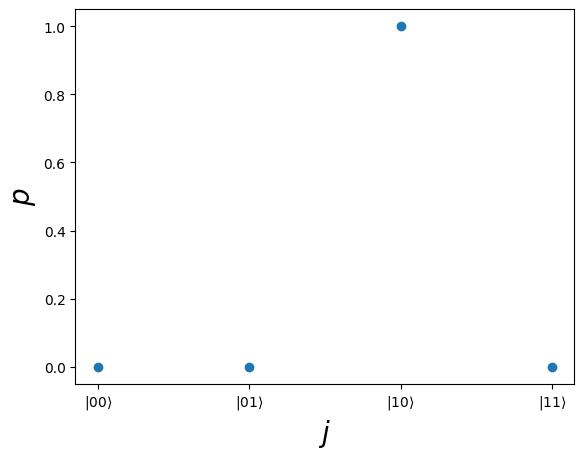

In [12]:
import matplotlib.pyplot as plt

# Create dictionary of results
data0 = data_raw.data.to_dict()
vec = [j for j in range(4)]
res = np.zeros(len(vec))
for jj in range(200):
    number = data0['x'][jj]
    res[number] += 1
res = res / 200.0

# Display plot of states
fig = plt.figure()
ax = fig.add_axes([0.16, 0.16, 0.78, 0.78])
ax.plot(vec, res, 'o')
ax.set_xticks(vec)
ax.set_xticklabels([r'$|00\rangle$', r'$|01\rangle$', r'$|10\rangle$', r'$|11\rangle$'])
plt.xlabel(r'$j$', fontsize=20)
plt.ylabel(r'$p$', fontsize=20)
plt.show()

In this particular case, it takes a single Grover iteration to find the correct result ($|10\rangle$) with 100% probability on a perfect device.

## Incorporate the effect of noise during a classical emulation of the circuit

Current NISQ processors are imperfect and prone to errors. We incorporated in Cirq a typical noise model for Pasqal devices, that can be used when one emulates the behavior of the device with a classical computer.

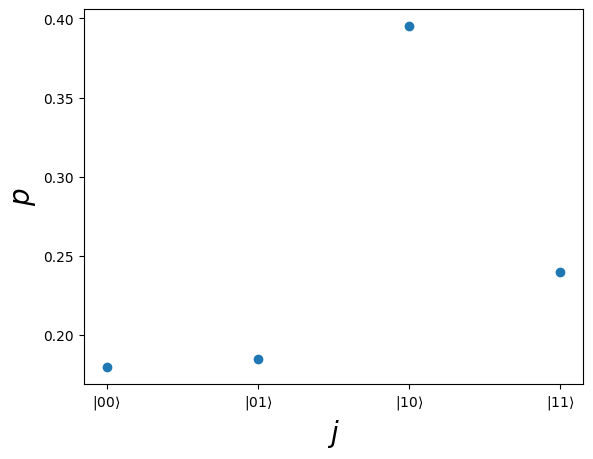

In [13]:
# Use the custom noise model of Pasqal devices
noise_model = PasqalNoiseModel(device)
grover_circuit = generate_pasqal_grover()
grover_circuit = grover_circuit.with_noise(noise_model)
grover_circuit.append(cirq.measure(*q_meas, key='x'))

# Run a simulation locally locally
data_raw = sampler.run(grover_circuit, repetitions=200)

# Plot the results
data0 = data_raw.data.to_dict()
vec = [j for j in range(4)]
res = np.zeros(len(vec))
for jj in range(200):
    number = data0['x'][jj]
    res[number] += 1
res = res / 200.0

fig = plt.figure()
ax = fig.add_axes([0.16, 0.16, 0.78, 0.78])
ax.plot(vec, res, 'o')
ax.set_xticks(vec)
ax.set_xticklabels([r'$|00\rangle$', r'$|01\rangle$', r'$|10\rangle$', r'$|11\rangle$'])
plt.xlabel(r'$j$', fontsize=20)
plt.ylabel(r'$p$', fontsize=20)
plt.show()

One still finds a rather large probability to measure $|10\rangle$, but we note the appearance of other measurement outcomes, due to the presence of noise.